In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pylab as plt
import cartopy.crs as ccrs
import cmocean
import copy as cp
from scipy.interpolate import griddata, interp1d
import pickle
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap
import cartopy as cr
import matplotlib.cm as cm
import matplotlib.colors as colors
from datetime import datetime, timedelta

In [2]:
Liste_h = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_'+'*_20_30_None_1994_0_1994.nc'))
ds_h = xr.open_dataset(Liste_h[0]) #travail avec n'importe quel dataset

In [3]:
ds_mask = xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_G12.nc')
ds_mask = ds_mask.set_coords({'nav_lat', 'nav_lon'}) #0 : terre, 1 : mer
ds_zgr = xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_zgr_12_with_latlon.nc')
ds_hgr = xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_hgr_12_CB.nc')
# gdepw_0 :thickness cellules verticales en point w
# hdepw : depth of the ocean ? depth of the deepest point w ? 

Goal : understand why dome particles die before the end of the run
Hypothesis : 
- advected southwad below 65 deg N - > normal
- go through the surface ? -> should be corrected ? 
- passes through the pole -> minimal ? 
- initialized on land/below ground level - fine to disregard
- touches the bottom of the ocean -> should not be a problem !! 

In [4]:
nmb_days  = 2*365+90+1
Counts = ds_h.count(dim = 'obs').time.values
Len_short =  np.where(np.array([Counts[j] - nmb_days + (pd.to_datetime(ds_h.isel(traj=j).isel(obs = 0).time.values)-datetime(1994,1,1, 12)).days for j in range(len(ds_h.traj.values))]) !=0)[0]
print('We have ', len(Len_short), ' particles deleted out of ', ds_h.traj.values[-1])

We have  3842  particles deleted out of  36399


In [5]:
def get_ORCA_index_fgrid(i, ds_h = ds_h):
    lon_i = ds_h.isel(traj=i).lon.values[0]
    lat_i = ds_h.isel(traj=i).lat.values[0]
    lons = ds_hgr.glamf.values[0,:,:]
    lats = ds_hgr.gphif.values[0,:,:]
    Dist = (lons-lon_i)**2+(lats-lat_i)**2
    a,b = np.unravel_index(Dist.argmin(), Dist.shape)
    return a,b

In [6]:
# all traj initialized on land
Len_land = Len_short[np.where(np.array([ds_mask.fmask.isel(t = 0).isel(z =0).values[get_ORCA_index_fgrid(i)] for i in Len_short])==0)[0]]
print('We have ', len(Len_land), ' particles initialized on land out of ',len(Len_short), 'short particles')

We have  420  particles initialized on land out of  3842 short particles


In [7]:
# all traj initialized below land level 
Len_subland = Len_short[np.where(np.array([ds_h.isel(traj = i).z[0].values - ds_zgr.hdepw[0, :,:].values[get_ORCA_index_fgrid(i)] for i in Len_short])>0)[0]]
print('We have ', len(Len_subland), ' particles initialized on land out of ',len(Len_short), 'short particles')

We have  338  particles initialized on land out of  3842 short particles


In [8]:
Len_65 = Len_short[np.where(np.array([ds_h.isel(traj = j).lat.values[np.where(~np.isnan(ds_h.isel(traj = j).lat.values))[0]][-1] for j in Len_short])<=65.5)[0]]
print('We have ', len(Len_65), ' particles crossing bering strait southward out of ',len(Len_short), 'short particles')

We have  1844  particles crossing bering strait southward out of  3842 short particles


In [9]:
Len_899 = Len_short[np.where(np.array([ds_h.isel(traj = j).lat.values[np.where(~np.isnan(ds_h.isel(traj = j).lat.values))[0]][-1] for j in Len_short])>=89.9)[0]]
print('We have ', len(Len_899), ' particles at North pole out of ',len(Len_short), 'short particles')

We have  0  particles at North pole out of  3842 short particles


In [10]:
Len_surf = Len_short[np.where(np.array([ds_h.isel(traj=i).z.values[np.where(~np.isnan(ds_h.isel(traj = i).z.values))][-1] - 0.1 for i in Len_short])<=0)[0]]
print('We have ', len(Len_surf), ' crossing the surface out of ',len(Len_short), 'short particles')

We have  1820  crossing the surface out of  3842 short particles


In [11]:
Len_all_problems = np.unique(np.concatenate((Len_surf, Len_899, Len_65, Len_subland, Len_land)))
print('We have ', len(Len_all_problems), ' identified out of ',len(Len_short), 'short particles')

We have  3674  identified out of  3842 short particles


In [12]:
Len_still_to_find = np.setdiff1d(Len_short, Len_all_problems)

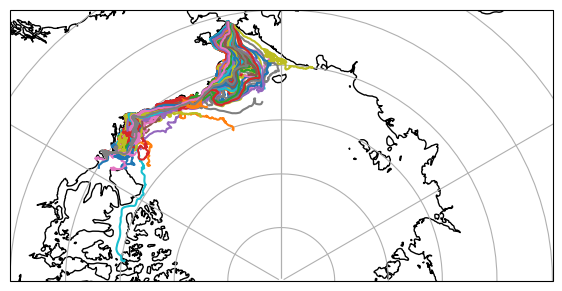

In [13]:
f = plt.figure(figsize = (7,7))
ax = f.add_subplot(1,1,1, projection = ccrs.NorthPolarStereo())
ax.coastlines()
#ds_mask.tmask.isel(t = 0).isel(z =0).plot.pcolormesh(ax = ax, x = 'nav_lon', y = 'nav_lat', transform = ccrs.PlateCarree(), add_colorbar = False)
#ax.set_extent([185, 195, 65, 67], crs=ccrs.PlateCarree())
ax.set_extent([90, 270, 65, 90], crs=ccrs.PlateCarree())
ax.gridlines()
for j in Len_still_to_find:
    ax.plot(ds_h.isel(traj = j).lon.values, ds_h.isel(traj = j).lat.values, transform = ccrs.PlateCarree())

In [14]:
L_dist_surf = []
for j in Len_still_to_find:
    ll = ds_h.count(dim = 'obs').time.values[j]
    L_dist_surf.append(ds_h.isel(traj = j).z.values[ll-1]-0.1)
L_dist_surf = np.array(L_dist_surf)
MAXI = np.max(L_dist_surf)

print('The distance max bewteen last point and 0.1 (surface) is', np.round(MAXI, 6), ' m, thus all points left also re-surface')

The distance max bewteen last point and 0.1 (surface) is 0.010981  m, thus all points left also re-surface


 All particles that are problematic (short) are either due to 
    - being initialized on land (OK)
    - being initialized below sea floor (OK)
    - aiming southward and leaving the domain (OK)
    - re-surfacing (either being below the threshold in their last point or just above, i.e. will cross at the next point)
How Possible that we have both ??? 